In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm
import cv2
from IPython.display import set_matplotlib_formats, HTML, Image, display
from loaders import load_all_videos, load_thumbnails, each_thumbnail, create_thumbs_df, load_thumbnail

%matplotlib inline
# set_matplotlib_formats('svg')

tqdm.tqdm.pandas()

sns.set()

def imshow(bgr):
    _,ret = cv2.imencode('.png', bgr)
    i = Image(data=ret)
    display(i)

def collage(images, rows=10, cols=10):
    w, h, d = sample[0].shape
    return np.array(sample).reshape(rows, cols, w, h, d).swapaxes(1, 2).reshape(rows * w, cols * h, d)

In [2]:
vids = load_all_videos()
load_thumbnails(vids)

100%|██████████| 8607/8607 [00:01<00:00, 5879.82it/s]

Downloaded: 0
Broken links: 0
Already present: 7928
Skipped: 679


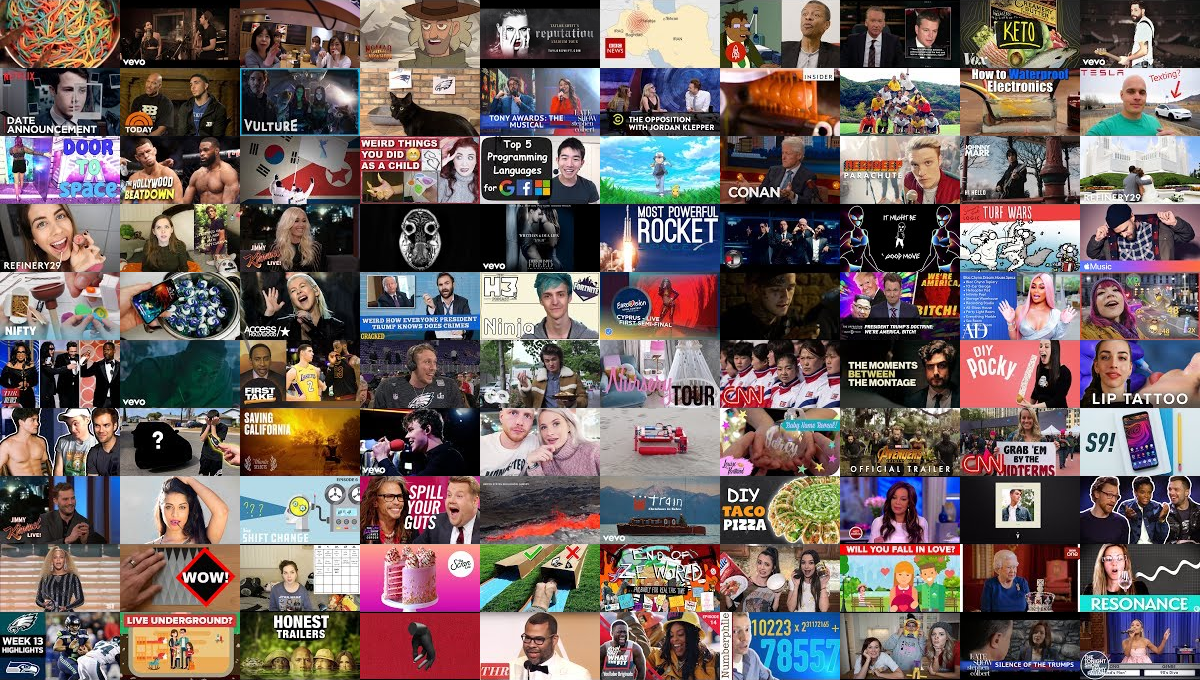

In [3]:
rows = 10
cols = 10
sample = [image for _, image in each_thumbnail(rows * cols)]
imshow(collage(sample))

## Color palette analysis

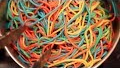

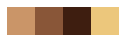

[Hsl(h=19, s=122, l=153), Hsl(h=15, s=107, l=96), Hsl(h=12, s=150, l=39), Hsl(h=28, s=190, l=180)]


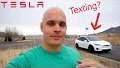

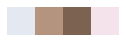

[Hsl(h=156, s=80, l=234), Hsl(h=16, s=66, l=153), Hsl(h=17, s=52, l=102), Hsl(h=236, s=120, l=236)]


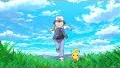

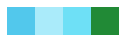

[Hsl(h=137, s=204, l=159), Hsl(h=135, s=226, l=210), Hsl(h=134, s=225, l=178), Hsl(h=93, s=156, l=85)]


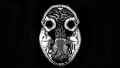

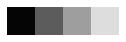

[Hsl(h=0, s=0, l=5), Hsl(h=0, s=0, l=92), Hsl(h=0, s=0, l=158), Hsl(h=0, s=0, l=221)]


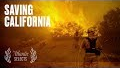

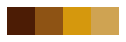

[Hsl(h=13, s=223, l=40), Hsl(h=21, s=192, l=81), Hsl(h=29, s=225, l=113), Hsl(h=27, s=144, l=144)]


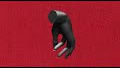

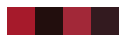

[Hsl(h=249, s=185, l=96), Hsl(h=2, s=113, l=23), Hsl(h=249, s=154, l=101), Hsl(h=246, s=82, l=38)]


In [4]:
import PIL
import colorgram

test = [sample[i] for i in [0, 19, 25, 33, 62, 93]]

def extract_palette(bgr):
    rgb = cv2.cvtColor(bgr, cv2.COLOR_BGR2RGB)
    img = PIL.Image.fromarray(rgb)
    return colorgram.extract(img, 4)

def show_palette(palette):
    swatch = np.array([[list(color.rgb) for color in palette]])
    plt.figure(figsize=(2,8))
    plt.imshow(swatch)
    plt.axis('off')
    plt.show()

for image in test:
    palette = extract_palette(image)
    imshow(image)
    show_palette(palette)
    print([color.hsl for color in palette])

In [5]:
thumbs = create_thumbs_df()
thumbs

video_id
0     AHIrklVaooQ
1     cKbl19xeSIQ
2     8WbxbqwdWog
3     R9s5_Ji33xY
4     66kn6Dcr12E
...           ...
7923  unX4FQqM6vI
7924  qaivW5joQrk
7925  G4BxOhJOmUw
7926  Dv4Ph97jv44
7927  8RsDxpyUa_U

[7928 rows x 1 columns]

In [6]:
hsl_zeros = { f"{x}{i}": 0 for i in range(4) for x in ['h', 's', 'l'] }
thumbs = thumbs.assign(**hsl_zeros)

def hsl_attributes(row):
    im = load_thumbnail(row['video_id'])
    for i, color in enumerate(extract_palette(im)):
        row[f"h{i}"] = int(color.hsl.h / 255 * 360)
        row[f"s{i}"] = int(color.hsl.s / 255 * 100)
        row[f"l{i}"] = int(color.hsl.l / 255 * 100)
    return row

thumbs = thumbs.progress_apply(hsl_attributes, axis=1)
thumbs

100%|██████████| 7928/7928 [04:25<00:00, 29.88it/s]


video_id   h0  s0  l0   h1  s1  l1   h2  s2  l2   h3  s3  l3
0     AHIrklVaooQ   26  47  60   21  41  37   16  58  15   39  74  70
1     cKbl19xeSIQ   18  40   7   21  25  34  240  60   0  139  60   0
2     8WbxbqwdWog   14  46  16   18  25  36  347  13  41  336  19  14
3     R9s5_Ji33xY   31  21  61   28  20  38   19  46  19   33  31  79
4     66kn6Dcr12E    0   6   2  240   2  15  343  15  13  347  16  37
...           ...  ...  ..  ..  ...  ..  ..  ...  ..  ..  ...  ..  ..
7923  unX4FQqM6vI  235  94  78   11  47  41   25  56  58  235  58  69
7924  qaivW5joQrk   25  29  12   22  23  61   19  25  38  213  14  12
7925  G4BxOhJOmUw  218  36   9   33  30  60   25  28  38  347  47  15
7926  Dv4Ph97jv44  303  37  12  321  22  38  259  33  17  313  20  62
7927  8RsDxpyUa_U   16  17  62   16  26  82   16  18  38   21  38  12

[7928 rows x 13 columns]

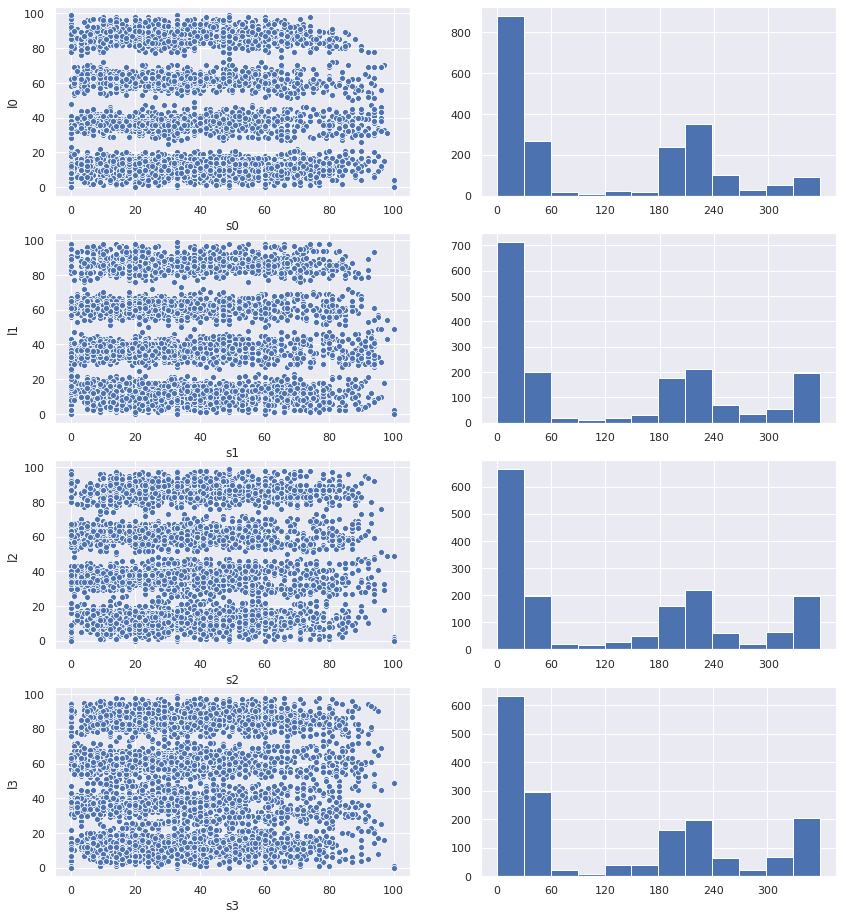

In [7]:
plt.figure(figsize=(14, 16))
for i in range(4):
    plt.subplot(4, 2, 2*i+1)
    sns.scatterplot(x=f"s{i}", y=f"l{i}", data=thumbs)
    plt.subplot(4, 2, 2*i+2)
    sl_filter = (thumbs[f"s{i}"] > 40) & (thumbs[f"s{i}"] > 30) & (thumbs[f"s{i}"] < 70)
    plt.hist(thumbs[sl_filter][f"h{i}"], bins=12)
    plt.xticks(np.arange(6) * 60)
plt.show()

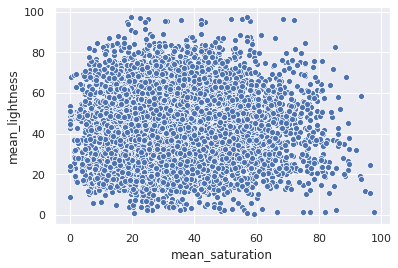

In [8]:
thumbs['mean_saturation'] = (thumbs['s0'] + thumbs['s1'] + thumbs['s2'] + thumbs['s3']) / 4
thumbs['mean_lightness'] = (thumbs['l0'] + thumbs['l1'] + thumbs['l2'] + thumbs['l3']) / 4

sns.scatterplot(x='mean_saturation', y='mean_lightness', data=thumbs)

(array([2536.,  762.,  477.,  325.,  249.,  228.,  288.,  497.,  848.,
        1718.]),
 array([  0.,  12.,  24.,  36.,  48.,  60.,  72.,  84.,  96., 108., 120.]),
 <a list of 10 Patch objects>)

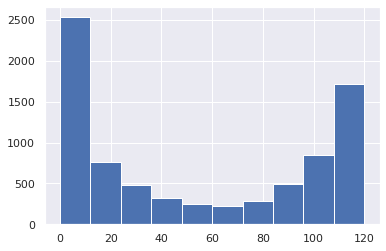

In [9]:
def hue_diff(a, b):
    diff = (a - b).abs()
    return np.array([diff, 360 - diff]).min(axis=0)

h01 = hue_diff(thumbs['h0'], thumbs['h1'])
h12 = hue_diff(thumbs['h1'], thumbs['h2'])
h20 = hue_diff(thumbs['h2'], thumbs['h0'])

mean_hue_diff = (h01 + h12 + h20) / 3
plt.hist(mean_hue_diff)

# Face analysis

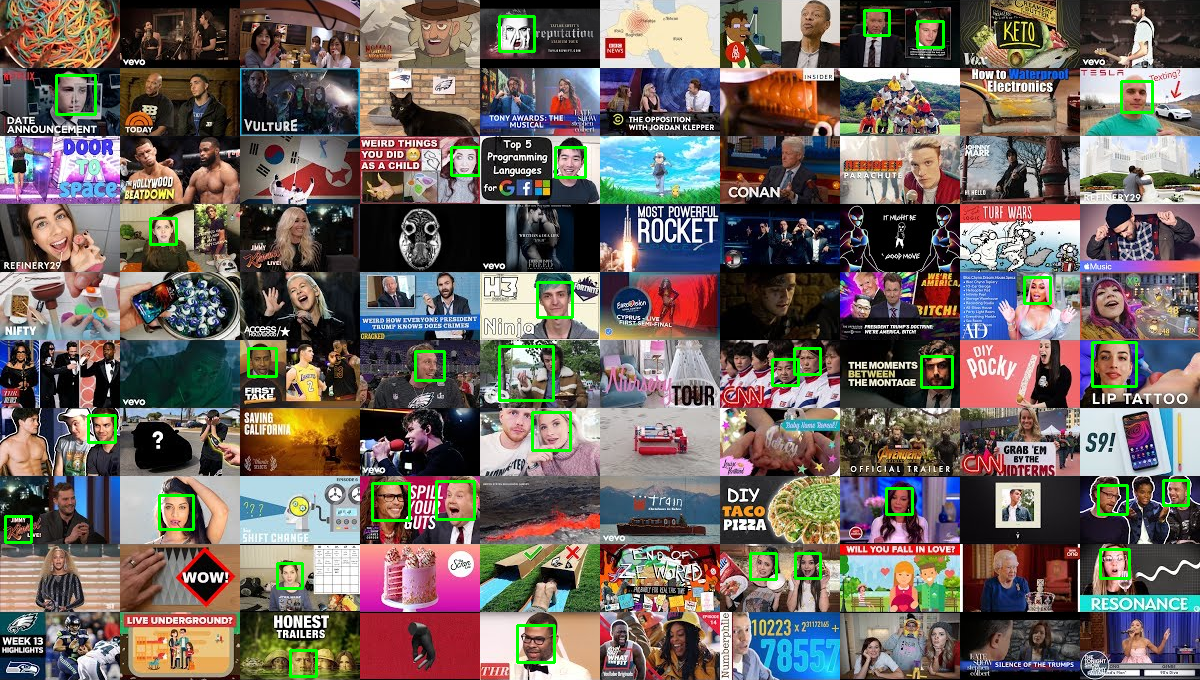

In [10]:
def detect_faces(thumbs):
    face_cascade = cv2.CascadeClassifier('../youtube_data/haarcascade_frontalface_default.xml')
    results = []
    for img in thumbs:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        faces = face_cascade.detectMultiScale(gray, 1.05, 3)
        
        for (x, y, w, h) in faces:
            cv2.rectangle(img, (x, y), (x + w, y + h), (0, 255, 0), 2)
        
        results.append(img)
    return results
    
rows = 10
cols = 10
sample = [image for _, image in each_thumbnail(rows * cols)]
sample = detect_faces(sample)

imshow(collage(sample))

In [11]:
thumbs = create_thumbs_df()
thumbs

video_id
0     AHIrklVaooQ
1     cKbl19xeSIQ
2     8WbxbqwdWog
3     R9s5_Ji33xY
4     66kn6Dcr12E
...           ...
7923  unX4FQqM6vI
7924  qaivW5joQrk
7925  G4BxOhJOmUw
7926  Dv4Ph97jv44
7927  8RsDxpyUa_U

[7928 rows x 1 columns]

In [12]:
face_cascade = cv2.CascadeClassifier('../youtube_data/haarcascade_frontalface_default.xml')

def detect_faces(row):
    img = load_thumbnail(row['video_id'])
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.1, 4)
    row['faces'] = faces
    row['faces_count'] = len(faces)
    
    return row

thumbs = thumbs.progress_apply(detect_faces, axis=1)
thumbs

100%|██████████| 7928/7928 [01:03<00:00, 125.76it/s]


video_id               faces  faces_count
0     AHIrklVaooQ                  ()            0
1     cKbl19xeSIQ                  ()            0
2     8WbxbqwdWog                  ()            0
3     R9s5_Ji33xY                  ()            0
4     66kn6Dcr12E  [[19, 16, 36, 36]]            1
...           ...                 ...          ...
7923  unX4FQqM6vI   [[61, 5, 29, 29]]            1
7924  qaivW5joQrk                  ()            0
7925  G4BxOhJOmUw                  ()            0
7926  Dv4Ph97jv44                  ()            0
7927  8RsDxpyUa_U  [[12, 11, 51, 51]]            1

[7928 rows x 3 columns]

count    7928.000000
mean        0.231963
std         0.483671
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         3.000000
Name: faces_count, dtype: float64
Thumbs with at least one face: 1634 (20.61% of all)


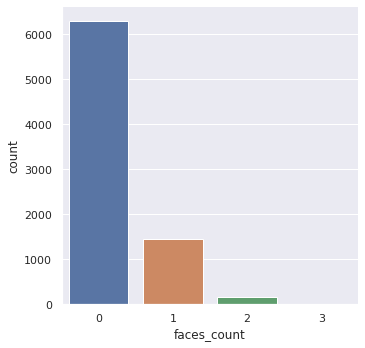

In [13]:
# how many thumbs have faces?
faces_per_thumb = thumbs['faces_count']

print(faces_per_thumb.describe())
sns.catplot(x="faces_count", kind="count", data=thumbs)

thumbs_with_faces = faces_per_thumb.where(faces_per_thumb > 0).count()
faces_ratio = round((thumbs_with_faces / len(thumbs) * 100), 3)
print("Thumbs with at least one face: " + str(thumbs_with_faces) + " (" + str(faces_ratio) + "% of all)")

## Text detection

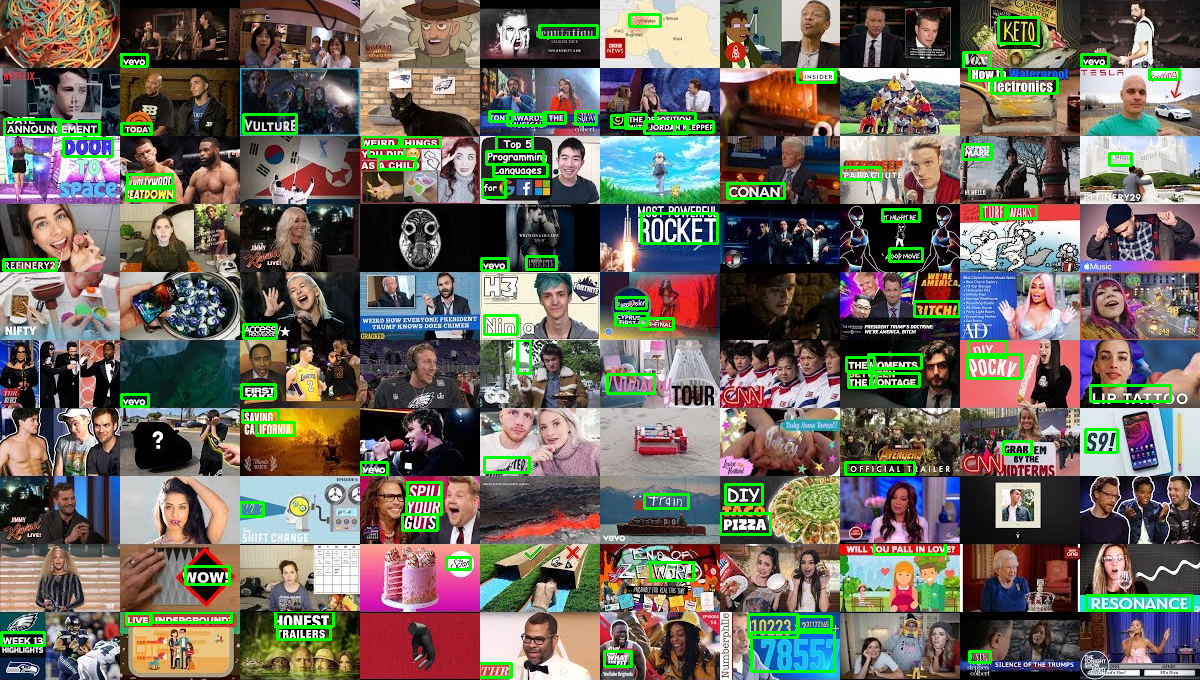

In [14]:
from text_detection import find_text, draw_bounding_boxes, boxes_area

sample = [image for _, image in each_thumbnail(rows * cols)]

for img in sample:
    boxes = find_text(img)
    draw_bounding_boxes(img, boxes)

imshow(collage(sample))

In [15]:
def detect_text(row):
    img = load_thumbnail(row['video_id'])
    boxes = find_text(img)
    row['text_area'] = boxes_area(img, boxes)
    return row

thumbs = thumbs.progress_apply(detect_text, axis=1)
thumbs

100%|██████████| 7928/7928 [10:50<00:00, 12.18it/s]


video_id               faces  faces_count  text_area
0     AHIrklVaooQ                  ()            0   0.000000
1     cKbl19xeSIQ                  ()            0   0.038235
2     8WbxbqwdWog                  ()            0   0.000000
3     R9s5_Ji33xY                  ()            0   0.000000
4     66kn6Dcr12E  [[19, 16, 36, 36]]            1   0.013235
...           ...                 ...          ...        ...
7923  unX4FQqM6vI   [[61, 5, 29, 29]]            1   0.000000
7924  qaivW5joQrk                  ()            0   0.041422
7925  G4BxOhJOmUw                  ()            0   0.037255
7926  Dv4Ph97jv44                  ()            0   0.000000
7927  8RsDxpyUa_U  [[12, 11, 51, 51]]            1   0.000000

[7928 rows x 4 columns]

In [28]:
thumbs['text_area'].describe()

count    7928.000000
mean        0.039971
std         0.061497
min         0.000000
25%         0.000000
50%         0.000000
75%         0.066176
max         0.505147
Name: text_area, dtype: float64

text_area
False    4385
True     3543
dtype: int64


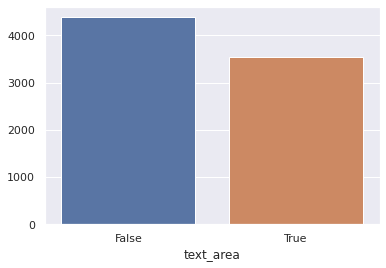

In [59]:
has_text = thumbs['text_area'] > 0
dist = thumbs.groupby(has_text).size()
print(dist)
sns.barplot(dist.index, dist.values)

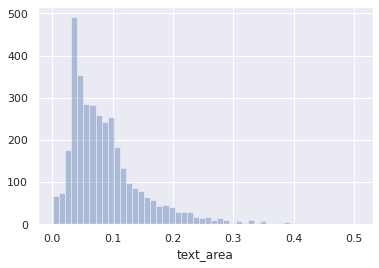

In [63]:
thumbs_with_text = thumbs[has_text]
sns.distplot(thumbs_with_text['text_area'], kde=False)